In [1]:
# IDEA: Add neck to the posture map?
from IPython import get_ipython

# %matplotlib qt
%load_ext autoreload
%autoreload 2

import time, os, sys, shutil
from utils.fitting_utils import *

# for math and plotting
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
#%matplotlib notebook
#%matplotlib widget
import scipy.stats as stats

from itertools import compress # for list selection with logical
from tqdm import tqdm

from multiprocessing import Process

# and pytorch
import torch

import sys, os, pickle
# import cv2
from colour import Color
import h5py
from tqdm import tqdm, tqdm_notebook
import glob
import itertools

In [2]:
# path to the neural data

ephys_folder = '/media/chrelli/SSD4TB/EPHYS_COPY/2020-11-10_10-19-39/'
# this is the female partner 
partner_sex = 'female'
tracking_folder = '/media/chrelli/SSD4TB/Data0_backup/recording_20201110-102009/'
rec_no = 0

# this is the male partner 
partner_sex = 'male'
tracking_folder = '/media/chrelli/SSD4TB/Data0_backup/recording_20201110-105540/'
rec_no = 3

In [4]:
# Data on Zenodo
ephys_folder = '/media/chrelli/SSD4TB/Ebbesen_Froemke_Final/ebbesen_froemke_2021_example_data/ephys_ir_data/2020-11-10_10-19-39/'

In [5]:
# load ephys


# Now, load some neurons sorted with phy

spike_index_phy = np.load(ephys_folder+
    "experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous/continuous-merged.GUI/"+
    "spike_times.npy")

spike_ids_phy = np.arange(len(spike_index_phy))

clusters_phy = np.load(ephys_folder+
    "experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous/continuous-merged.GUI/"+
    "spike_clusters.npy")

templates = np.load(ephys_folder+
    "experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous/continuous-merged.GUI/"+
    "templates.npy")

cluster_info = pd.read_csv(ephys_folder+
    "experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous/continuous-merged.GUI/"+
    "cluster_info.tsv", sep='\t') 

phy_params_path = ephys_folder+"experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous/continuous-merged.GUI/"+                    "params.py"

# also parse the recording start synch time!!!

with open (ephys_folder+
    "experiment1/recording1/sync_messages.txt", "r") as myfile:
    sync_messages=myfile.readlines()


sample_rate = 30000.

# filter only good cells
cluster_info = cluster_info[cluster_info.group == 'good'] #.sort_values(by = 'amp')
cluster_info.head()


,id,amp,ch,depth,fr,group,n_spikes,purity,sh
0,1,88.586761,0,162.5,14.249379,good,53164,0.933629,0.0
4,8,146.340454,18,50.0,0.133477,good,498,0.824229,0.0
6,12,88.986717,24,75.0,21.205748,good,79118,0.909716,0.0
7,13,306.912354,19,100.0,2.061126,good,7690,0.993872,0.0
11,19,91.618080,1,137.5,3.762293,good,14037,0.793313,0.0


In [6]:
# extract the recording start from the sync_messages by a regular expr
import re
rec_start_sample= int(re.findall(r'[0-9]+@',sync_messages[1])[0][:-1])
print("recording started at sample # {}".format(rec_start_sample))
ephys_rec_start_sample = rec_start_sample
ephys_rec_start_time = rec_start_sample/sample_rate

recording started at sample # 4325632


In [7]:
# and save all the spike trains
n_neurons = cluster_info.shape[0]

i_neuron = 10

# let's get it in seconds!
spike_times = spike_index_phy[clusters_phy == cluster_info.id.values[i_neuron]]/sample_rate + ephys_rec_start_time

spike_time_holder = []
for i_neuron in range(n_neurons):
    spike_times = spike_index_phy[clusters_phy == cluster_info.id.values[i_neuron]]/sample_rate + ephys_rec_start_time
    spike_time_holder.append(spike_times)


In [8]:
timing_male = pickle.load( open( ephys_folder+'timing_male.pkl', "rb" ) )
tracked_behavior_male = pickle.load( open( ephys_folder+'tracked_behavior_male.pkl', "rb" ) )

timing_female = pickle.load( open( ephys_folder+'timing_female.pkl', "rb" ) )
tracked_behavior_female = pickle.load( open( ephys_folder+'tracked_behavior_female.pkl', "rb" ) )



In [11]:
# plot histograms of the durations of the events!

fps = 60 # TODO clean this up 
em = timing_male['event_times_ephys']
ef = timing_female['event_times_ephys']
event_start = [np.hstack([ef[i],em[i]]) for i in range(3)]
em = timing_male['event_duration']
ef = timing_female['event_duration']
event_duration = [np.hstack([ef[i],em[i]])/fps for i in range(3)]


In [12]:
# calculate median durations!

med_dur_f = [np.median(x)/fps for x in ef]
med_dur_m = [np.median(x)/fps for x in em]

p_mf = [sp.stats.mannwhitneyu(em[i],ef[i])[1] for i in range(3)]


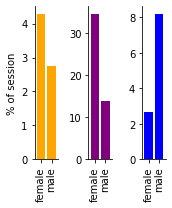

In [14]:
# make bargraphs of the total time spent

dur_f = np.array([np.sum(x)/fps for x in ef])
dur_m = np.array([np.sum(x)/fps for x in em])


total_dur_f = np.diff(timing_female['reference_stamps_ephys_time'][[0,-1]])/1e3
total_dur_m = np.diff(timing_male['reference_stamps_ephys_time'][[0,-1]])/1e3

rel_dur_f = 100*dur_f/total_dur_f
rel_dur_m = 100*dur_m/total_dur_m

event_colors = ['orange','purple','blue']


plt.figure(figsize = (2.5,3) )
for i in range(3):
    plt.subplot(1,3,1+i)

    plt.bar([0,1],[rel_dur_f[i],rel_dur_m[i]],width = .8,facecolor = event_colors[i])
#     plt.ylim(0,.35)

    if i == 0:
        plt.ylabel('% of session')
    plt.xlim([-.6,1.6])
    ax = plt.gca()
    plt.savefig('revision_figures/psth/total_durations.png',dpi = 200,facecolor='w')
    ax.set_xticks([])
    ax.set_xticks([0,1])
    ax.set_xticklabels(['female','male'],rotation = 90)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)  


  
plt.subplots_adjust(wspace = 0)    

# plt.tight_layout()
plt.tight_layout()
plt.savefig('revision_figures/psth/total_durations.png',dpi = 200,facecolor='w',pad_inches=10)
plt.show()

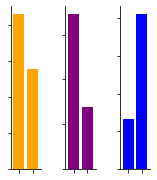

In [15]:
# make bargraphs of the total time spent

dur_f = np.array([np.sum(x)/fps for x in ef])
dur_m = np.array([np.sum(x)/fps for x in em])


total_dur_f = np.diff(timing_female['reference_stamps_ephys_time'][[0,-1]])/1e3
total_dur_m = np.diff(timing_male['reference_stamps_ephys_time'][[0,-1]])/1e3

rel_dur_f = 100*dur_f/total_dur_f
rel_dur_m = 100*dur_m/total_dur_m

event_colors = ['orange','purple','blue']


plt.figure(figsize = (2.5,3) )
for i in range(3):
    plt.subplot(1,3,1+i)

    plt.bar([0,1],[rel_dur_f[i],rel_dur_m[i]],width = .8,facecolor = event_colors[i])
#     plt.ylim(0,.35)

    if i == 0:
        pass
#         plt.ylabel('% of session')
    plt.xlim([-.6,1.6])
    ax = plt.gca()
    plt.savefig('revision_figures/psth/total_durations.png',dpi = 200,facecolor='w')
    ax.set_xticks([])
    ax.set_xticks([0,1])
    ax.set_yticklabels('')
    ax.set_xticklabels('')

#     ax.set_xticklabels(['female','male'],rotation = 90)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)  
    if i == 1:
        pass
    if i == 0:
        ax.set_yticks([0,1,2,3,4])
    if i == 1:
        ax.set_yticks([0,10,20,30])
    if i == 2:        
        ax.set_yticks([0,2,4,6,8])
    

  
plt.subplots_adjust(wspace = .8)    

# plt.tight_layout()
# plt.tight_layout()
plt.savefig('revision_figures/psth/total_durations_clean.png',dpi = 200,facecolor='w',pad_inches=10)
plt.show()

In [16]:
# in order to handle everything, we make one long list of all the covariates that we care about


fps = 60 # TODO clean this up 
em = timing_male['event_times_ephys']
ef = timing_female['event_times_ephys']
event_start = [np.hstack([ef[i],em[i]]) for i in range(3)]

em = timing_male['event_duration']
ef = timing_female['event_duration']
event_duration = [np.hstack([ef[i],em[i]])/fps for i in range(3)]

event_sex = [np.hstack([np.zeros(ef[i].shape[0]),np.ones(em[i].shape)]) for i in range(3)]

# event_sex = [np.hstack([['f']*ef[i].shape[0],['m']*ef[i].shape[0] ]) for i in range(3)]
n_events = [len(x) for x in event_duration]
types =  ['n2n','n0t1','n1t0']
event_type = [[types[i]]*n_events[i] for i in range(3)]
event_sex_i = np.hstack(event_sex)
event_sex = []
for j in range(len(event_sex_i)):
    if event_sex_i[j] == 0:
        event_sex.append('f')
    else:
        event_sex.append('m')
        
event_type = np.hstack(event_type)
event_duration = np.hstack(event_duration)
event_start = np.hstack(event_start)

# # sort all the events by their start time
sidx = np.argsort(event_start)

event_start=event_start[sidx]
event_duration=event_duration[sidx]
event_type=event_type[sidx]
event_sex_i=event_sex_i[sidx]
event_sex =np.array(event_sex)[sidx]
# event_sex

p = 0.09168527510987085, N = 105 v 51
p = 0.07075356798471248, N = 221 v 101
p = 8.444988244174285e-05, N = 64 v 46


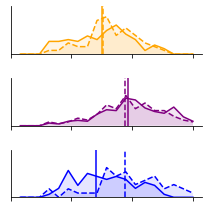

In [20]:
# plot the distributions with a male and female

edges = np.linspace(np.log(.01),np.log(10),20)
plt.figure(figsize=(3,3))
for i_event,ty in enumerate(types):
    plt.subplot(3,1,1+i_event)

    log_dur_f = np.log( event_duration[(event_sex=='f')*(event_type == ty)] )
    log_dur_m = np.log( event_duration[(event_sex=='m')*(event_type == ty)] )

    count_f,_ = np.histogram(log_dur_f,edges)
    count_m,_ = np.histogram(log_dur_m,edges)

    count_f = count_f/np.sum(count_f)
    count_m = count_m/np.sum(count_m)

    xx = edges[:-1] + np.median(np.diff(edges))

    plt.plot(xx,count_f,'-',c = event_colors[i_event])
    plt.plot(xx,count_m,'--',c = event_colors[i_event])

    
    plt.fill(np.hstack([xx,np.flipud(xx)]), np.hstack([count_f,np.zeros_like(xx)]), 
             facecolor=event_colors[i_event], alpha=0.1)
    
    plt.fill(np.hstack([xx,np.flipud(xx)]), np.hstack([count_m,np.zeros_like(xx)]), 
             facecolor=event_colors[i_event], alpha=0.1)
    
    plt.axvline(np.median(log_dur_f),color = event_colors[i_event])
    plt.axvline(np.median(log_dur_m),color = event_colors[i_event],linestyle='--')

    #     plt.plot(xx,count_m,'--',c = event_colors[i_event])

    
    ticks = [np.log(.01),np.log(.1),np.log(1),np.log(10)]
    plt.xticks(ticks)
    ax = plt.gca()
    ax.set_xticks(ticks)
    ax.set_ylim([0,.25])
    ax.set_xticklabels('')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)  

    ax.set_xticklabels('')
    ax.set_yticks([])
    
    print("p = {}, N = {} v {}".format(sp.stats.mannwhitneyu(log_dur_f,log_dur_m)[1], len(log_dur_f), len(log_dur_m)))
ax.set_xticklabels('')

plt.tight_layout()
plt.subplots_adjust(hspace = .5, wspace = .1)
plt.savefig('revision_figures/psth/hist_durations.png',dpi = 200,facecolor='w',pad_inches=10)
plt.show()


In [21]:
sp.stats.mannwhitneyu(log_dur_f,log_dur_m)

MannwhitneyuResult(statistic=851.0, pvalue=8.444988244174285e-05)

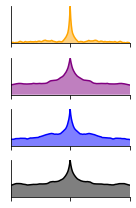

In [14]:
# Calculate the autocorrelation between events!
plt.figure(figsize = (2,3))
for i_event,ty in enumerate(np.hstack([types,'all'])):
    plt.subplot(4,1,1+i_event)

    if ty  =='all':
        start_time = event_start
        end_time = event_start + event_duration
        cc = 'k'
    else:
        start_time = event_start[event_type == ty]
        end_time = event_start[event_type == ty] + event_duration[event_type == ty]
        cc = event_colors[i_event]

    dt = .05
    running_time = np.arange(start_time[0],end_time[-1],dt)

    logic = np.zeros_like(running_time)

    for ss,ee in zip(start_time,end_time):
        logic[ (running_time >= ss)*(running_time < ee) ] = 1
    
    lr =len(running_time)
    xx = np.arange(-lr+1,lr)*dt
    window = 6000
    # acorr = np.convolve(logic,logic,'full')
    from scipy import signal
    acorr = signal.correlate(logic,logic,'full')
    yy  =acorr/np.max(acorr)
    plt.plot(xx,yy,c=cc)
    
    plt.fill(np.hstack([xx,np.flipud(xx)]), np.hstack([yy,np.zeros_like(xx)]), 
             facecolor=cc, alpha=.5)
    
#     plt.bar(xx,acorr/np.max(acorr))
    plt.xlim([-20,20])
    plt.ylim([0,1])
#     plt.xticks([-30,0,30])
    plt.yticks([])
    ax = plt.gca()
    ax.set_xticklabels('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)  
plt.subplots_adjust(hspace = 0.1)
plt.tight_layout()
plt.savefig('revision_figures/psth/acorr_durations.png',dpi = 200,facecolor='w',pad_inches=10)


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log


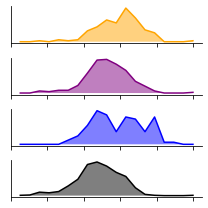

In [15]:

# Calculate the autocorrelation between events!



# Calculate the autocorrelation between events!
plt.figure(figsize = (3,3))
for i_event,ty in enumerate(np.hstack([types,'all'])):
    plt.subplot(4,1,1+i_event)

    if ty  =='all':
        start_time = event_start
        end_time = event_start + event_duration
        
        cc = 'k'
        
        # do the slow way!
        isi=end_time-start_time
        for ii,st in enumerate(start_time):
            if ii ==0:
                continue
            isis = st - end_time
            isis = isis[isis>0]
            isi[ii] = np.min(isis)
        
    else:
        start_time = event_start[event_type == ty]
        end_time = event_start[event_type == ty] + event_duration[event_type == ty]
        cc = event_colors[i_event]
    
        isi=start_time[1:] - end_time[:-1]

    edges = np.linspace(np.log(.01),np.log(1000),20)
  
    count,_ = np.histogram(np.log(isi),edges)
    xx = edges[:-1] + np.median(np.diff(edges))

    plt.plot(xx,count,c=cc)
    
    
    plt.fill(np.hstack([xx,np.flipud(xx)]), np.hstack([count,np.zeros_like(xx)]), 
             facecolor=cc, alpha=.5)
    
#     plt.bar(xx,acorr/np.max(acorr))
#     plt.xlim([-20,20])
#     plt.ylim([0,1])
    plt.xticks(np.log(np.array([.01,.1,1,10,100,1000])))
    plt.yticks([])
    ax = plt.gca()
    ax.set_xticklabels('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)  
plt.subplots_adjust(hspace = 0.1)
plt.tight_layout()
plt.savefig('revision_figures/psth/isi_distribution.png',dpi = 200,facecolor='w',pad_inches=10)


In [18]:
def psth_test(spike_times, event_times):
    pre_time = 5
    post_time = 5

    aligned_spikes = []
    counts = []
    for i,et in enumerate(event_times):
        st = spike_times[( spike_times >= (et-pre_time) )*( spike_times < (et+post_time) ) ] - et
        aligned_spikes.append(st)

        # bin the counts
        dtime = 0.25
        edges = np.arange(-pre_time,post_time,dtime)
        count,edges = np.histogram(st,edges)
        counts.append(count)


    counts = np.vstack(counts)    

    pre_rate = np.sum(counts[:,(edges[:-1] >= -4)*(edges[:-1] < -2)],axis = 1)/2
    post_rate = np.sum(counts[:,(edges[:-1] >= -.5)*(edges[:-1] < .5)],axis = 1)/1
    W,pval_rate = sp.stats.wilcoxon(pre_rate,post_rate)
    return pre_rate,post_rate,W,pval_rate

In [ ]:
# plot a badge with wave and autocorrelation

from utils.spikes import ax_paint_raster,ax_paint_psth,ax_paint_common_yaxis,ax_paint_acorr,ax_paint_waves
import matplotlib.patches as patches

for i_neuron in [13,12,20,21,26,27]:    
# for i_neuron in [4]:
# for i_neuron in [13]:
    
    fig = plt.figure(figsize = (4,5))
    
    gspec = fig.add_gridspec(ncols=3, nrows=2,height_ratios=[8,1])
    
    psth_axes = []
    spike_times = spike_time_holder[i_neuron]
#     plt.subplot(2,3,1)


    ax = fig.add_subplot(gspec[0, 0])
#     ax_paint_acorr(ax,spike_times)

    cluster_id = cluster_info.id.values[i_neuron]
    ax_paint_waves(ax,cluster_id,phy_params_path,spike_index_phy,clusters_phy,
                   linecolor= 'k',dotcolor ='w',all_channels = True)
    ax.axis('off')
    
    ax = fig.add_subplot(gspec[1, 0])

    ax_paint_acorr(ax,spike_times,facecolor = 'k')    
    
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    plt.savefig('revision_figures/psth/badge_i_neuron_{}.png'.format(i_neuron),dpi = 200,pad_inches=2,transparent=True)
    
    plt.show()
    
    
    

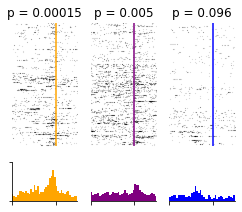

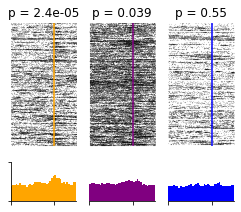

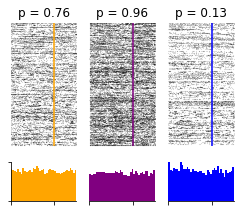

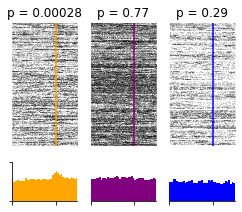

In [44]:
# NOW, we make a raster plot where we show the events as well!

from utils.spikes import ax_paint_raster,ax_paint_psth,ax_paint_common_yaxis
import matplotlib.patches as patches

plt.close('all')

rate_pre_holder = [[],[],[]]
rate_post_holder = [[],[],[]]
pval_holder = [[],[],[]]
W_holder = [[],[],[]]

i_neuron = 13
# for i_neuron in range(31):


clean = False

# for i_neuron in [13,12,20,21,26,27]:    
for i_neuron,yyylim in zip([13,20,21,26],[10,45,17,35]):    

# for i_neuron in [13]:
    
    plt.figure(figsize = (4,5))
    psth_axes = []
    spike_times = spike_time_holder[i_neuron]
    # select what event to plot?
    for i_event,event in enumerate(['n2n','n0t1','n1t0']):

        plt.subplot(2,3,1+i_event)
        ax = plt.gca()

        event_times = event_start
        event_dur = event_duration

        target_logic = event_type == event

        # clean up the event times!
        pre_time=4
        long_break = np.hstack([False,(event_times[1:]-(event_times[:-1]+event_dur[:-1])) > pre_time])

        if clean:
            target_times = event_start[target_logic*long_break]
            target_dur = event_duration[target_logic*long_break]
            target_sex = event_sex[target_logic*long_break]
        else:
            target_times = event_start[target_logic]
            target_dur = event_duration[target_logic]    
            target_sex = event_sex[target_logic]

#         long_break = np.hstack([False,(target_times[1:]-(target_times[:-1]+target_dur[:-1])) > pre_time])
#         target_times = target_times[long_break]
#         target_dur = target_dur[long_break]
#         target_sex = target_sex[long_break]

        def clean_events_times(event_times,pre_time = 2):
            # optional: clean the event times!                
            # we discard the first one, because we can't know
            # TODO should prob also cross check with the other events?
            long_break = np.hstack([False,(event_times[1:]-(event_times[:-1]+event_dur[:-1])) > pre_time])
            event_times= event_times[long_break]
            return event_times

        def ax_paint_events(ax,event_times,event_dur,color = 'peru',buff = 10,pre_time=2,clean=True):
            # paint the event times!
            if clean:
                # check end of previous event!
                long_break = np.hstack([False,(event_times[1:]-(event_times[:-1]+event_dur[:-1])) > pre_time])

                event_times= event_times[long_break]
                event_dur = event_dur[long_break]
            # loop over and paint everything within 10 secs
            for ii,et in enumerate(event_times):
                shifted_events = event_times-et
                in_buff = (shifted_events>=-buff)*(shifted_events<buff)
                shifted_events = shifted_events[in_buff]
                shifted_dur = event_dur[in_buff]

                for sh,d in zip(shifted_events,shifted_dur):
    #                 ax.plot([sh,sh+d],ii*np.ones(2),'-o',c=color)

                    ax.add_patch(
                        patches.Rectangle(
                            (sh, ii),   # (x,y)
                            d,          # width
                            1,          # height
                            fill=True,
                            zorder=2,
                            color = color

                            )
                        )

    #     ax_paint_events(ax,event_times,event_dur)
    #     event_times =  clean_events_times(event_times)
        plt.xlim([-1,1])
        
        if clean:
            #clean
            dz = .5
        else:
            #dirty
            dz = .1
        ax_paint_raster(ax,spike_times,target_times,dotsize=dz, pre_time = 4, post_time =2, dotcolor = 'k', linecolor = event_colors[i_event])
        ax.axis('off')
        
        
        rate_pre,rate_post,W,pval=psth_test(spike_times, target_times)
        
        rate_pre_holder[i_event].append(rate_pre)
        rate_post_holder[i_event].append(rate_post)
        pval_holder[i_event].append(pval)
        W_holder[i_event].append(W)

        plt.title('p = {0:.2g}'.format(pval))

        plt.subplot(6,3,6+4+i_event)
        ax = plt.gca()
        ax.set_xticks([-4,0])
               
        ax_paint_psth(ax,spike_times, target_times, pre_time = 4, post_time =2, facecolor = event_colors[i_event],line = False)
#         ax.set_ylim(0,10)
#         ax.axis('off')
    
    
        psth_axes.append(ax)
        
        ax.spines['top'].set_visible(False)
        
        ax.spines['right'].set_visible(False)
        if i_event > 0:
            ax.set_ylabel('')
            ax.set_yticks([])
            ax.spines['left'].set_visible(False)
        if not clean:
            ax.set_xticklabels('')
            ax.set_xticklabels('')
            ax.set_xlabel('')
            ax.set_ylabel('')
            
    ax_paint_common_yaxis(psth_axes)
    
    for ax in psth_axes:
        ax.set_ylim([0,yyylim])
        ax.set_xticklabels('')        
        ax.set_yticklabels('')
        ax.set_xlabel('')
        ax.set_ylabel('')


    psth_axes[0].set_yticks([0,yyylim])
    
    if clean:
        plt.savefig('revision_figures/psth/clean_psth_{}.png'.format(i_neuron),dpi = 200,pad_inches=2,transparent=True)
        stat_master_clean = {'pre':rate_pre_holder, 'post':rate_post_holder, "W":W_holder, "pval": pval_holder}
    else:
        plt.savefig('revision_figures/psth/dirty_psth_{}.png'.format(i_neuron),dpi = 200,pad_inches=2,transparent=True)
        stat_master_dirty = {'pre':rate_pre_holder, 'post':rate_post_holder, "W":W_holder, "pval": pval_holder}
    plt.show()
    
    
# stat_master_clean = {'pre':rate_pre_holder, 'post':rate_post_holder, "W":W_holder, "pval": pval_holder}
# stat_master_dirty = {'pre':rate_pre_holder, 'post':rate_post_holder, "W":W_holder, "pval": pval_holder}

    
    

 10%|▉         | 3/31 [00:00<00:01, 25.62it/s]/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
  0%|          | 0/31 [00:00<?, ?it/s]/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
100%|██████████| 31/31 [00:00<00:00, 139.47it/s]


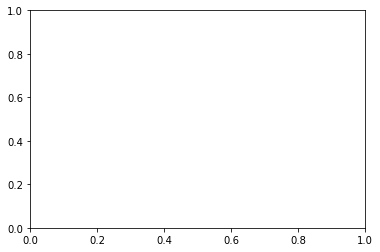

In [19]:
# JUST RUN TO GET THE STATS



# NOW, we make a raster plot where we show the events as well!

from utils.spikes import ax_paint_raster,ax_paint_psth,ax_paint_common_yaxis
import matplotlib.patches as patches

plt.close('all')

for clean in [False,True]:


    rate_pre_holder = [[],[],[]]
    rate_post_holder = [[],[],[]]
    pval_holder = [[],[],[]]
    W_holder = [[],[],[]]

    i_neuron = 13



    # for i_neuron in [13,12,20,21,26,27]:    
    for i_neuron in tqdm(range(31)):

    # for i_neuron in [13]:

        psth_axes = []
        spike_times = spike_time_holder[i_neuron]
        # select what event to plot?
        for i_event,event in enumerate(['n2n','n0t1','n1t0']):

            ax = plt.gca()

            event_times = event_start
            event_dur = event_duration

            target_logic = event_type == event

            # clean up the event times!
            pre_time=4
            long_break = np.hstack([False,(event_times[1:]-(event_times[:-1]+event_dur[:-1])) > pre_time])

            if clean:
                target_times = event_start[target_logic*long_break]
                target_dur = event_duration[target_logic*long_break]
                target_sex = event_sex[target_logic*long_break]
            else:
                target_times = event_start[target_logic]
                target_dur = event_duration[target_logic]    
                target_sex = event_sex[target_logic]


            rate_pre,rate_post,W,pval=psth_test(spike_times, target_times)

            rate_pre_holder[i_event].append(rate_pre)
            rate_post_holder[i_event].append(rate_post)
            pval_holder[i_event].append(pval)
            W_holder[i_event].append(W)

        if clean:
            stat_master_clean = {'pre':rate_pre_holder, 'post':rate_post_holder, "W":W_holder, "pval": pval_holder}
        else:
            stat_master_dirty = {'pre':rate_pre_holder, 'post':rate_post_holder, "W":W_holder, "pval": pval_holder}


    # stat_master_clean = {'pre':rate_pre_holder, 'post':rate_post_holder, "W":W_holder, "pval": pval_holder}
    # stat_master_dirty = {'pre':rate_pre_holder, 'post':rate_post_holder, "W":W_holder, "pval": pval_holder}


    


18 clean 11 dirty
8 clean 8 dirty
0 clean 2 dirty
18 clean 11 dirty
8 clean 8 dirty
0 clean 2 dirty


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


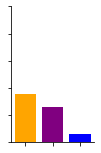

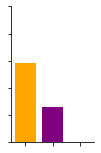

In [22]:

for clean in [False,True]:
    plt.figure(figsize = (1.5,2.5))
    for i_event in range(3):
        pre = np.array([np.mean(x) for x in stat_master_clean['pre'][i_event]])
        post = np.array([np.mean(x) for x in stat_master_clean['post'][i_event]])
        mod_clean = (post-pre)/(post+pre)

        mod_clean = np.log(post/pre)

        pre = np.array([np.mean(x) for x in stat_master_dirty['pre'][i_event]])
        post = np.array([np.mean(x) for x in stat_master_dirty['post'][i_event]])
        mod_dirty = (post-pre)/(post+pre)

        mod_dirty = np.log(post/pre)

        p_clean = np.array(stat_master_clean['pval'][i_event])
        p_dirty = np.array(stat_master_dirty['pval'][i_event])
        n_clean = np.sum(p_clean <0.05)
        n_dirty = np.sum(p_dirty <0.05)

        edges = np.linspace(np.log(1/8),np.log(8),12)
        count_clean,edges = np.histogram(mod_clean,edges)
        count_dirty,edges = np.histogram(mod_dirty,edges)

        if clean:
            plt.bar(i_event,n_clean/n_neurons,facecolor = event_colors[i_event])
        else:
            plt.bar(i_event,n_dirty/n_neurons,facecolor = event_colors[i_event])
        
        print("{} clean {} dirty".format(n_clean,n_dirty))

    plt.ylim([0,1])
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticklabels('')
    plt.xticks([0,1,2])
    ax.set_xticklabels('')

    
    
    if clean:
        plt.savefig('revision_figures/psth/n_clean.png'.format(i_neuron),dpi = 200,pad_inches=2,transparent=True)
    else:
        plt.savefig('revision_figures/psth/n_dirty.png'.format(i_neuron),dpi = 200,pad_inches=2,transparent=True)
            

#     plt.title("{0:.2g} vs {0:.2g} signif".format(pd,pc))
#     plt.axvline(np.mean(mod_dirty),c='k')
#     plt.axvline(np.mean(mod_clean),c='r')
#     plt.ylim([0,25])

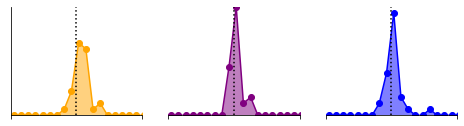

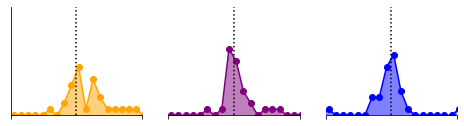

In [38]:


for clean in [False  , True]:

    plt.figure(figsize = (8,2))
    for i_event in range(3):
        if clean:
            pre = np.array([np.mean(x) for x in stat_master_clean['pre'][i_event]])
            post = np.array([np.mean(x) for x in stat_master_clean['post'][i_event]])
        else:
            pre = np.array([np.mean(x) for x in stat_master_dirty['pre'][i_event]])
            post = np.array([np.mean(x) for x in stat_master_dirty['post'][i_event]])

        mod  = (post-pre)/(post+pre)

        edges = np.arange(-2,2,.11)
        count,edges = np.histogram(mod,edges)

        plt.subplot(1,3,1+i_event)

    #     plt.plot(edges[:-1]+np.median(np.diff(edges))/2,count_dirty,'.:')
        xx = edges[:-1]+np.median(np.diff(edges))/2
        plt.plot(xx,count,'o-',c=event_colors[i_event])

        plt.fill(np.hstack([xx,np.flipud(xx)]), np.hstack([count,np.zeros_like(xx)]), 
                 facecolor=event_colors[i_event], alpha=.5)

        plt.axvline(0,color = 'k',linestyle=':')

        _,pval = sp.stats.wilcoxon(mod)

#         plt.title("{0:.2g} vs {0:.2g} signif".format(pval,pval))
    #     plt.axvline(np.mean(mod_dirty),c='k')
    #     plt.axvline(np.mean(mod_clean),c='r')
        if clean:
            plt.ylim([0,18])
        else:
            plt.ylim([0,18])
        plt.xlim([-1,1])
        plt.xticks([-1,1])

        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        ax.set_yticks([])

    #     ax.set_xticks(np.log(np.array([1/8,1/4,1/2,1,2,4,8])))
    #     ax.set_xticklabels(['1\n--\n8','1\n--\n4','1\n--\n2','1','2','4','8'])

#         plt.axvline(np.mean(mod),color =event_colors[i_event])

        if i_event > 0:
            ax.spines['left'].set_visible(False)
            ax.set_yticks([])

    plt.subplots_adjust(hspace = 0.1)
    if clean:
        plt.savefig('revision_figures/psth/idx_clean.png'.format(i_neuron),dpi = 200,pad_inches=2,transparent=True)
    else:
        plt.savefig('revision_figures/psth/idx_dirty.png'.format(i_neuron),dpi = 200,pad_inches=2,transparent=True)


    plt.show()

    